In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from IPython.display import Markdown, display
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import label_binarize, StandardScaler
from scipy.stats import norm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
import warnings 
warnings.filterwarnings('ignore')


def printmd(string):
    display(Markdown(string))

pd.options.display.float_format = '{:.2f}'.format


In [2]:
from FCG.Optika import Optika
    


In [3]:
df = pd.read_csv("credit_train.csv")


In [4]:
df["Loan Status"].map({"Fully Paid": 1, "Charged Off": 0})
df.drop_duplicates(inplace=True)
na = df[df['Loan ID'].isnull()].index.tolist()
df.drop(na, inplace=True)
df = df.drop(['Months since last delinquent'], axis=1)
df.dropna(thresh=13, inplace=True)
mapping_dict = {
    "Years in current job": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0
    }
}

df.replace(mapping_dict, inplace=True)
df["Years in current job"].fillna(0, inplace=True)

In [5]:
category_cols = df.select_dtypes(include=['object']).columns # DOOBI: typo - category_cols
for col in category_cols:
    df[col] = df[col].astype('category')
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].cat.codes 
numeric_cols = df.select_dtypes(include=['int64','float64']).columns 
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)
info_cols = ['Loan ID', 'Customer ID']

In [6]:
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6697,48724,1,445412.00,1,709.00,1167493.00,8.00,1,5,5214.74,17.20,6.00,1.00,228190.00,416746.00,1.00,0.00
1,23041,14688,1,262328.00,1,1130.83,1375894.39,10.00,1,3,33295.98,21.10,35.00,0.00,229976.00,850784.00,0.00,0.00
2,25441,30541,1,99999999.00,1,741.00,2231892.00,8.00,2,3,29200.53,14.90,18.00,1.00,297996.00,750090.00,0.00,0.00
3,38341,74173,1,347666.00,0,721.00,806949.00,3.00,2,3,8741.90,12.00,9.00,0.00,256329.00,386958.00,0.00,0.00
4,68058,41470,1,176220.00,1,1130.83,1375894.39,5.00,3,3,20639.70,6.10,15.00,0.00,253460.00,427174.00,0.00,0.00


In [7]:
X = df.drop("Loan Status", axis=1).drop(info_cols, axis = 1)
y = df["Loan Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)


In [9]:
config = {"features_to_change": ['Current Loan Amount', 'Term', 'Credit Score',
                                 'Annual Income', 'Years in current job', 'Home Ownership', 'Purpose',
                                 'Monthly Debt', 'Years of Credit History', 'Number of Open Accounts'],
          "increase_features": ['Credit Score', 'Annual Income'],
          "categorical columns": list(category_cols),
          "numerical columns" : list(numeric_cols),
          "n_counerfactuals": 1,
          "max_features_to_change": 2,
          "ID": 'Loan ID',
          "target": 'Loan Status'}


In [10]:
obs = X.loc[[52872,]]
obs

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,98340.00,0,6840.00,1222954.00,4.00,1,9,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00


In [11]:
op = Optika(pd.concat([X,y], axis = 1), log_reg, config, target_class=1)

In [12]:
idx_box = op.box(obs, 15000)
len(idx_box)

29170

In [13]:
52872 in idx_box

True

In [14]:
X_st, y, obs_st = op.pre_process(obs)

In [15]:
obs_st

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.39,-1.67,4.10,-0.16,-0.43,-0.98,2.32,-0.64,-0.68,-0.82,-0.35,0.62,0.03,-0.33,-0.11


In [15]:
obs_st = X_st.loc[[52872,]]
obs_st

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.39,-1.67,4.10,-0.16,-0.43,-0.98,2.32,-0.64,-0.68,-0.82,-0.35,0.62,0.03,-0.33,-0.11


In [16]:
features_to_use = op.find_feature_importance_regression()

In [17]:
op.features_to_use

['Credit Score', 'Current Loan Amount']

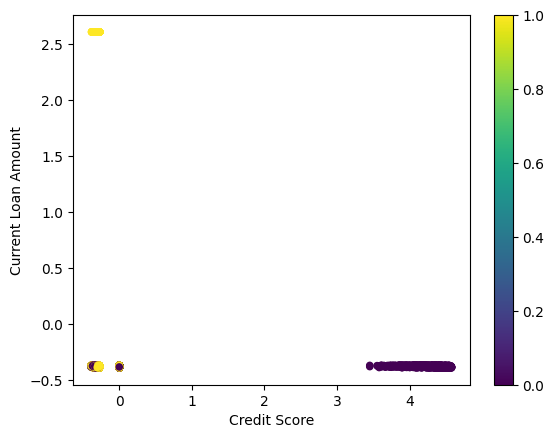

In [18]:
X_st.plot.scatter(x = 'Credit Score',y = 'Current Loan Amount',  c= y, cmap = 'viridis')
plt.show()

In [19]:
op.X_st.loc[[52872,]]

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
52872,-0.39,-1.67,4.10,-0.16,-0.43,-0.98,2.32,-0.64,-0.68,-0.82,-0.35,0.62,0.03,-0.33,-0.11


In [20]:
slice = op.slicing()  #we cut the subset for search, close to given instance

In [21]:
op.slice

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
14267,-0.38,-1.67,-0.29,-0.10,-0.70,-0.98,1.43,-0.26,-0.58,-0.42,-0.35,0.82,0.01,-0.33,-0.11
56171,-0.38,-1.67,-0.31,-0.46,0.10,-0.98,1.43,-0.42,-0.38,-0.22,-0.35,0.75,0.06,-0.33,-0.11
57466,-0.38,-1.67,-0.29,-0.68,-0.43,-0.98,3.21,-0.98,-0.09,-0.42,-0.35,0.36,0.01,-0.33,-0.11
68487,2.61,-1.67,-0.34,-0.05,-0.43,0.07,3.21,-0.37,-0.38,-0.82,-0.35,0.69,0.02,-0.33,-0.11
88804,-0.38,-1.67,0.00,0.00,-0.70,-0.98,1.43,-1.11,-0.97,-0.42,-0.35,-0.24,0.01,-0.33,-0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,-0.38,-1.67,-0.30,-0.26,-0.70,-0.98,-0.35,-0.47,0.45,-0.62,-0.35,0.82,0.02,-0.33,-0.11
93778,-0.38,-1.67,-0.30,-0.10,-0.97,-0.98,-0.35,-0.01,-0.86,-0.62,-0.35,-0.22,-0.00,-0.33,-0.11
24498,-0.39,-1.67,-0.29,-0.68,-0.70,-0.98,-0.35,0.05,-0.15,-0.22,-0.35,0.61,0.00,-0.33,-0.11
25172,-0.38,-1.67,-0.28,0.41,-0.70,-0.98,-0.35,-0.21,-1.14,-0.02,-0.35,0.74,0.03,-0.33,-0.11


In [22]:
#here we are looking for density areas
# first argument - determines the min number the cluster should contain
# second argument is the number of clusters to search in
radius, data_res = op.optics(2,7)

In [23]:
radius

array([4.48791752, 4.53126186, 4.53299144, 4.54616504, 4.55489586,
       4.56208826, 4.58974357])

In [24]:
data_res  #centroids of result clusters

,labels,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,67,-0.38,-1.67,-0.17,-0.11,0.90,-0.98,3.21,0.07,0.31,-0.12,-0.35,1.14,0.08,-0.33,-0.11
1,1,-0.38,-1.67,-0.30,-0.35,-0.84,-0.98,0.54,-0.09,-0.41,-0.92,-0.35,0.91,0.06,-0.33,-0.11
2,0,-0.38,-1.67,-0.30,-0.28,-0.30,-0.98,1.43,-0.34,-0.48,-0.32,-0.35,0.78,0.03,-0.33,-0.11
3,51,-0.38,-1.67,-0.16,-0.24,-1.44,-0.98,0.65,-0.44,0.18,0.28,-0.35,0.64,0.07,-0.33,-0.11
4,58,-0.38,-1.67,-0.32,-0.19,-0.97,-0.98,3.21,0.20,0.20,0.04,-0.35,0.15,0.01,-0.33,-0.11
5,76,-0.38,-1.67,-0.15,-0.09,-1.24,0.07,0.54,-1.38,-1.78,-1.22,-0.35,-0.67,-0.01,-0.33,-0.11
6,64,-0.39,-1.67,-0.10,-0.23,-0.70,0.07,2.61,-0.03,-0.35,1.04,-0.35,-0.54,0.01,-0.33,-0.11


In [29]:
#cfs - counterfactual
# d - distance between instance and counterfactual, standartized
# n - number of neighbors (radius = 1) in the original dataset
cfs,d,n = op.generate()

In [26]:
len(d), len(n)

(56, 56)

In [30]:
x = np.array(d).reshape(len(d),-1)
y = np.array(n).reshape(len(n),-1)
c = ['r', 'g', 'b', 'k', 'y'] * 12

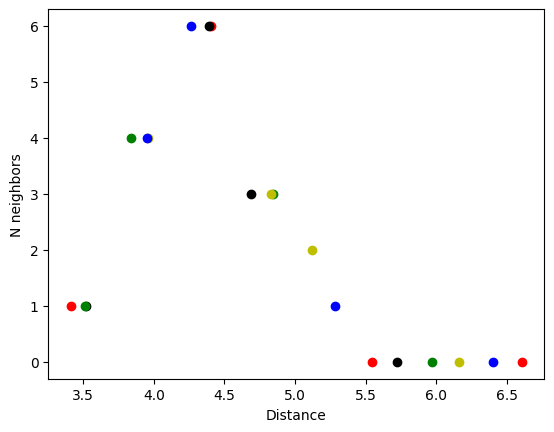

In [31]:
# the trade-off between the distance and density

plt.figure()
for i in range(20):
    plt.scatter(x = x[i,], y = y[i,], c = c[i])
plt.xlabel('Distance')
plt.ylabel('N neighbors')
plt.show()

In [45]:
d = pd.Series(d)
mask = d[d < 4.5].index
mask

Int64Index([0, 1, 2, 8, 9, 10, 16, 17, 18, 24, 25, 26, 32, 33, 34, 40, 41, 42,
            48, 49, 50],
           dtype='int64')

In [48]:
#resulting counterfactual dataset
cfs.iloc[mask,]

,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,296920.80,0.00,2085.93,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,321743.40,0.00,1491.67,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,346566.00,0.00,897.42,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,434112.80,0.00,1933.20,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,476084.40,0.00,1319.85,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,518056.00,0.00,706.50,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,295495.20,0.00,1942.80,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,320139.60,0.00,1330.65,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,344784.00,0.00,718.50,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
0,373639.20,0.00,2094.73,1222954.00,4.00,1.00,9.00,10619.29,13.50,7.00,0.00,523450.00,1005158.00,0.00,0.00
